<h1> <center> Towards more complicated structures... and more noise </center></h1>

In this notebook, we assess our method on multiple synthetic graphs where the structural role of each node is known and is used as ground truth information to evaluate performance. This extends the noisy setting described in the paper: the goal is to see how well our algorithm performs in more "realistic", noisier settings. 

__Generation mechanism:__ The graphs are given by generating 10 instances of patterns of 3 different types (''house'', ''fan'', ''star'' ). For combination of types (``varied'') 
that are placed randomly along the 'super-nodes' of a backbone graph.
![title](../plots/supergraph2.pdf)


In the "noise-free" setting, this backbone graph is a cycle (see notebook synthetic_experiment1 for further details), and the patterns are regularly attached along the nodes of the cycle. The symmetry is very well defined and our algorithm is able to detect structural equivalences. We now want to increase the difficulty of the task by mimicking real networks and generating  backbone graphs according to more realistic network models (Preferential Attachment or a Small-World network). In these settings, each small pattern is assigned to super-node of this backbone structure whose  edges dictate the inter-connectivity of the different patterns. This setting is characterized by a large amount of noise, since the structural equivalence classes are perturbed by the edges connecting the patterns.

__Evaluation strategy:__  The setting is now a lot more noisy then before (notebook synthetic_experiment1), so we need many different metrics to completely grasp te performance of the algorithms. For each graph, we run different structural role discovery methods, and we then evaluate performance using the following  metrics on the structural signatures returned by the methods.
+ Cluster homogeneity score when we run k-means on the resulting embeddings (with k equal to the true number of roles). This is the conditional entropy of the known roles given the proposed clustering~\citep{rosenberg2007v}. 
+ Cluster completeness score for k-means on the embeddings~\citep{rosenberg2007v}, which evaluates the clustering method's ability to group all the members of a given class in the same cluster.  This reflects whether the roles recovered by the method are well separated.
+ The 4-nearest neighbor purity: since we have generated 5 instances of each shape, the best algorithm should aim to recover 4 nearest neighbors of the same class.
+ An F-statistic, defined as:
	$$ F= \frac{ \text{Between-class variance}}{\text{Within-class variance}  }=\frac{ \frac{1}{K-1} \sum_k  |C_k| (\bar{Y}_k-\bar{Y})^2 }{ \frac{1}{N-K} \sum_k \sum_{i \in C_k} (Y_{i}-\bar{Y}_k)^2   }$$
	where $K$ is the number of roles, $\bar{Y}$ is the overall mean embedding, and the $\bar{Y}_k$ are the centroids of the different (ground-truth) clusters $C_k$.
	This metric compares the ratio of the overall variance with respect to the distances between nodes within each cluster. Ideally, if the algorithm correctly separates classes, this statistic should be large.
+ The median  ratio of  cluster variance over overall variance: $\text{Var}=\text{Median} [\frac{ \frac{1}{|C_k|-1} \sum_{i \in C_k}  (Y_i-\bar{Y}_k)^2 }{ \frac{1}{N-1} \sum_i (Y_{i}-\bar{Y})^2   }]$.  This measures how dense the clusters are with respect to the overall variance of the representations.
+ The number of insightful contrasts $N_{\text{ contrasts}}$, that is, the number of pairwise distances classes for which $d(C_i, C_{j})^2>4\text{Var}(C_i) \quad(*)$. Whenever (*) is realized, the distance between clusters $C_i$ and $C_j$ is on average above $2$ standard deviations of points in cluster $i$, and the algorithm can separate the classes well. 




In [1]:
%matplotlib inline
import numpy as np
import networkx as nx 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import matplotlib.pyplot as plt
import sys
import pickle
import seaborn as sb
sys.path.append( '../../structural_equivalents/')
#sys.path.append('/Users/cdonnat/Desktop/structural_equivalents/')
from SC import *
from distances_signature import *
from shapes.shapes import *
from heat_diffusion import *
from clustering_via_distances import *
import graph_tools 
from utils import *
#from stats.statistic_checks import *
from purity import *
from characteristic_functions import *
from clustering_comparative_analysis import *
from cluster_analysis import *
from performance_evaluation import *
#import sys
#sys.path.append( '../structural_equivalents/struc2vec_alg/src')

In [2]:
# 1- Start by defining our favorite regular structure

################################### EXAMPLE TO BUILD A SIMPLE REGULAR STRUCTURE ##########
## REGULAR STRUCTURE: the most simple structure:  basis + n small patterns of a single type

list_shapes=[["fan",6]]*7+[["star",5]]*7+[["house"]]*7

## Regular symmetric model: Cycle graph

In [ ]:

B=20
name_graph='regular_cycle'
width_basis=42
basis_type="cycle" 
G,colors_shape, plugins,colors=build_structure(width_basis,basis_type,list_shapes, start=0,add_random_edges=0,plot=False,savefig=False)
A=nx.adjacency_matrix(G).todense()
nb_clust=len(np.unique(colors))
taus=range(1,20)
heat_print=heat_diffusion(G,taus,diff_type="immediate",type_graph="nx")
D={}
chi={}
Perf={}
N=nx.number_of_nodes(G)
D_classes={}
D_var={}
Ff_reg={k:[] for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']}
Varr_reg={k:[] for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']}
### 2. Conduct the comparative analysis described in the introduction passing these wavelets as input
load_data_from_cache=True
if !load_data_from_cache:
    for b in range(B):
        D[b], chi[b], Perf[b],D_classes[b],D_var[b]=clustering_comparative_analysis(G, colors, \
           heat_print,nb_clust,dirpath='../../structural_equivalents',\
           graph_nodes_name=name_graph+'_nodes.txt',graph_edges_name=name_graph+'_edges.txt',\
           agg_max=5,struc2vec_input=name_graph+'_edges.txt',\
           struc2vec_output=name_graph+'_struc2vec.txt')

        for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']:
            Dd, F,Var_within, Var_between=F_test(chi[b][k], colors)
            def square(x): return x**2
            myfunc=np.vectorize(square)
            m=np.array([chi[b][k].mean(0)]*N).reshape((N,-1))
            Var=1.0/(N-1)*myfunc(chi[b][k]-m).sum()
            Ff_reg[k].append(F)
            Varr_reg[k].append(np.median(np.diag(1.0/Var*D_var[b][k])))
    data=[D, chi, Perf,D_classes,D_var,Ff_reg,Varr_reg]
    with open('../caches/reg_trials.pkl', "wb") as f:
        pickle.dump(data, f)
else:
    with open('../caches/reg_trials.pkl', "rb") as f:
        D, chi, Perf,D_classes,D_var,Ff_reg,Varr_reg=pickle.load(f)

In [ ]:
D

## WS- Model

In [ ]:
D_WS06={}
chi_WS06={}
Perf_WS06={}
D_classes_WS06={}
D_var_WS06={}
name_graph='WS_3_06plus30'
perf={}
Ff_WS06={k:[] for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']}
Varr_WS06={k:[] for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']}
D_var_WS06_tot={}
D_classes_WS06_tot={}


load_data_from_cache=True
if !load_data_from_cache:
    for i in range(20):
        G,colors, index_roles, label_shape=build_lego_structure_from_structure(list_shapes, start=0,plot=True,savefig=False,graph_type='nx.connected_watts_strogatz_graph', graph_args=[3,0.6],save2text='/Users/cdonnat/Desktop/structural_equivalents/graphs/WS_3_06plus30_',add_node=21)
        taus=range(1,20,1)
        N=nx.number_of_nodes(G)
        nb_clust=len(np.unique(index_roles))
        heat_print=heat_diffusion(G,taus,diff_type="immediate",type_graph="nx")
        D_WS06[i], chi_WS06[i], Perf_WS06[i],D_classes_WS06[i],D_var_WS06[i]=clustering_comparative_analysis(G, index_roles, heat_print,nb_clust,dirpath='../../structural_equivalents',\
                                                                                            graph_nodes_name=name_graph+'_nodes.txt',graph_edges_name=name_graph+'_edges.txt',\
                                                                                              agg_max=5,struc2vec_input=name_graph+'_edges.txt',struc2vec_output=name_graph+'_struc2vec.txt')
        #try:
         #   D_var_WS06_tot={k:D_var_WS06_tot[k]+D_var_WS06[k] for k in D_var_WS06.keys()}
         #   D_classes_WS06_tot={k:D_classes_WS06_tot[k]+D_classes_WS06[k] for k in D_var_WS06.keys()}
        #except:
            #print 'dict not updated'
            ##D_var_WS06_tot={k:D_var_WS06[k] for k in D_var_WS06.keys()}
            #D_classes_WS06_tot={k:D_classes_WS06[k] for k in D_var_WS06.keys()}
        for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']:
            D, F,Var_within, Var_between=F_test(chi_WS06[i][k], index_roles)
            def square(x): return x**2
            myfunc=np.vectorize(square)
            m=np.array([chi_WS06[i][k].mean(0)]*N).reshape((N,-1))
            Var=1.0/(N-1)*myfunc(chi_WS06[i][k]-m).sum()
        Ff_WS06[k].append(F)
        Varr_WS06[k].append(np.median(np.diag(1.0/Var*D_var_WS06[i][k])))
    data=[D_WS06, chi_WS06, Perf_WS06,D_classes_WS06,D_var_WS06,Ff_WS06,Varr_WS06]
    with open('../caches/WS06_trials.pkl', "wb") as f:
        pickle.dump(data, f)    
else:
    with open('../caches/WS06_trials.pkl', "rb") as f:
        D_WS06, chi_WS06, Perf_WS06,D_classes_WS06,D_var_WS06,Ff_WS06,Varr_WS06=pickle.load(data, f)  
    

#### WS 3,0.3 plus 30

In [ ]:
D_WS03={}
chi_WS03={}
Perf_WS03={}
D_classes_WS03={}
D_var_WS03={}
name_graph='WS_3_03plus30'
load_data_from_cache=True
if !load_data_from_cache:
    for i in range(30):
        G,colors, index_roles, label_shape=build_lego_structure_from_structure(list_shapes, start=0,plot=True,savefig=False,graph_type='nx.connected_watts_strogatz_graph', graph_args=[3,0.3],save2text='/Users/cdonnat/Desktop/structural_equivalents/graphs/WS_3_03plus30_',add_node=21)
        taus=range(1,20,1)
        heat_print=heat_diffusion(G,taus,diff_type="immediate",type_graph="nx")
        perf={}
        N=nx.number_of_nodes(G)
        nb_clust=len(np.unique(index_roles))
        D_WS03[i], chi_WS03[i], Perf_WS03[i],D_classes_WS03[i],D_var_WS03[i]=clustering_comparative_analysis(G, index_roles, heat_print,nb_clust,dirpath='../../structural_equivalents',graph_nodes_name=name_graph+'_nodes.txt',graph_edges_name=name_graph+'_edges.txt',agg_max=5,struc2vec_input=name_graph+'_edges.txt',struc2vec_output=name_graph+'_struc2vec.txt')
    data=[D_WS03, chi_WS03, Perf_WS03,D_classes_WS03,D_var_WS03]
    with open('../caches/WS03_trials.pkl', "wb") as f:
        pickle.dump(data, f)   
else:
    with open('../caches/WS03_trials.pkl', "wb") as f:
        D_WS03, chi_WS03, Perf_WS03,D_classes_WS03,D_var_WS03=pickle.load(f) 
    

In [ ]:
Perf_WS06_tot=pd.DataFrame(np.zeros(Perf_WS06[0].shape),index=Perf_WS06[0].index, columns=Perf_WS06[0].columns)
for k in Perf_WS06.keys():
    Perf_WS06_tot+=Perf_WS06[k]

### WS 1, 0.6 plus 30

In [ ]:
name_graph='WS_1_06plus30'
G,colors, index_roles, label_shape=build_lego_structure_from_structure(list_shapes, start=0,plot=True,savefig=False,graph_type='nx.connected_watts_strogatz_graph', graph_args=[2,0.3],save2text='/Users/cdonnat/Desktop/structural_equivalents/graphs/WS_1_06plus30_',add_node=21)
taus=range(1,20,1)
heat_print=heat_diffusion(G,taus,diff_type="immediate",type_graph="nx")
perf={}
N=nx.number_of_nodes(G)
nb_clust=len(np.unique(index_roles))
Ff_WS1_06={k:[] for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']}
Varr_WS1_06={k:[] for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']}
D_var_WS1_06_tot={}

D_WS1_06={}
chi_WS1_06={}
Perf_WS1_06={}
D_classes_WS1_06={}
D_var_WS1_06={}

if !load_data_from_cache:
    
    for i in range(20):
        G,colors, index_roles, label_shape=build_lego_structure_from_structure(list_shapes, start=0,plot=True,savefig=False,graph_type='nx.connected_watts_strogatz_graph', graph_args=[3,0.6],save2text='/Users/cdonnat/Desktop/structural_equivalents/graphs/WS_3_06plus30_',add_node=30)
        taus=range(1,20,1)
        heat_print=heat_diffusion(G,taus,diff_type="immediate",type_graph="nx")
        D_WS1_06[i], chi_WS1_06[i], Perf_WS1_06[i],D_classes_WS1_06[i],D_var_WS1_06[i]=clustering_comparative_analysis(G, index_roles, heat_print,nb_clust,dirpath='../../structural_equivalents',graph_nodes_name=name_graph+'_nodes.txt',graph_edges_name=name_graph+'_edges.txt',agg_max=5,struc2vec_input=name_graph+'_edges.txt',struc2vec_output=name_graph+'_struc2vec.txt')
        for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']:
            D, F,Var_within, Var_between=F_test(chi_WS1_06[i][k], index_roles)
            def square(x): return x**2
            myfunc=np.vectorize(square)
            m=np.array([chi_WS1_06[i][k].mean(0)]*N).reshape((N,-1))
            Var=1.0/(N-1)*myfunc(chi_WS1_06[i][k]-m).sum()
            Ff_WS1_06[k].append(F)
            Varr_WS1_06[k].append(np.median(np.diag(1.0/Var*D_var_WS1_06[i][k])))


    data=[D_WS1_06, chi_WS1_06, Perf_WS1_06,D_classes_WS1_06,D_var_WS1_06,Ff_WS1_06,Varr_WS1_06]
    with open('../caches/WS1_06_trials.pkl', "wb") as f:
        pickle.dump(data, f)  
else:
    with open('../caches/WS1_06_trials.pkl', "wb") as f:
        D_WS1_06, chi_WS1_06, Perf_WS1_06,D_classes_WS1_06,D_var_WS1_06,Ff_WS1_06,Varr_WS1_06=pickle.load( f)  

## PA Model

#### PA 1 plus 30 nodes

start= 0
start= 7
start= 14
start= 21
start= 28
start= 35
start= 42
start= 49
start= 55
start= 61
start= 67
start= 73
start= 79
start= 85
start= 91
start= 96
start= 101
start= 106
start= 111
start= 116
start= 121


2017-10-10 08:55:26,139:[INFO](pygsp.filters.filter.__init__): Heat : has to compute lmax
2017-10-10 08:55:26,297:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:55:26,352:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:55:26,389:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:55:26,420:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:55:26,457:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:55:26,505:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:55:26,549:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:55:26,583:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:55:26,628:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:55:26,658:[INFO](pygsp.filters.filter.analysis): The analysis method

Creating Vertex Features matrix
V is a 147 by 112 matrix.
Node-role matrix is of dimensions 147 by 10
[[  1.69900000e+03   1.61325967e-01   1.40000000e+01 ...,   1.54161252e-02
    1.54161252e-02   1.40000000e+01]
 [  0.00000000e+00   1.39180172e-01   4.00000000e+00 ...,   4.83941978e-03
    4.83941978e-03   4.00000000e+00]
 [  1.00000000e+00   1.39312977e-01   6.00000000e+00 ...,   6.87195374e-03
    6.87195374e-03   6.00000000e+00]
 ..., 
 [  0.00000000e+00   1.42300195e-01   2.00000000e+00 ...,   2.92644814e-03
    2.92644814e-03   2.00000000e+00]
 [  0.00000000e+00   1.02312544e-01   2.00000000e+00 ...,   3.17339864e-03
    3.17339864e-03   2.00000000e+00]
 [  1.41000000e+03   1.43842365e-01   4.00000000e+00 ...,   4.58300243e-03
    4.58300243e-03   4.00000000e+00]]
[[ 0.          0.          0.          0.00427097  0.01699066  0.          0.
   0.        ]
 [ 0.          0.01695854  0.          0.01518342  0.00454554  0.          0.
   0.        ]
 [ 0.          0.11623688  0.036

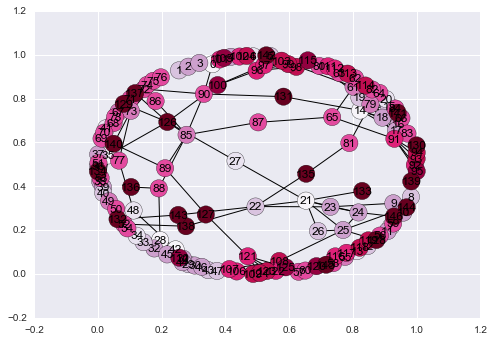

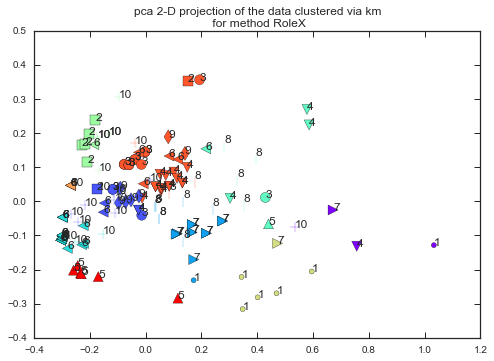

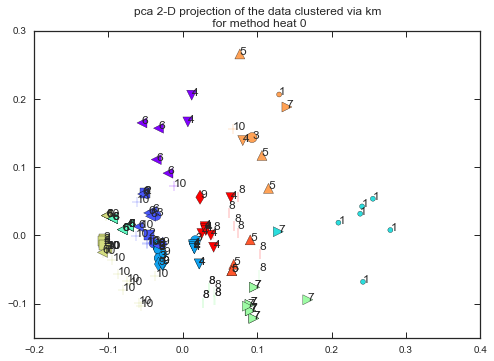

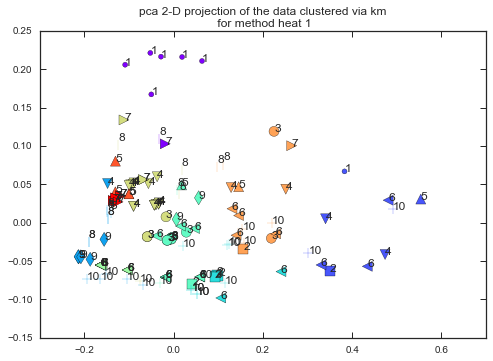

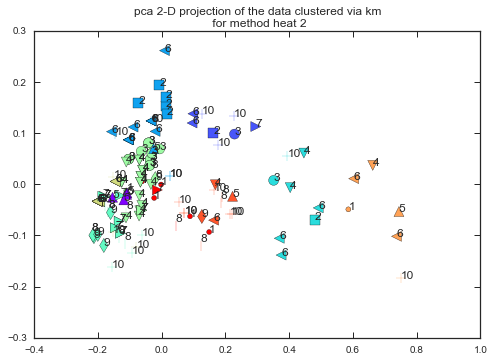

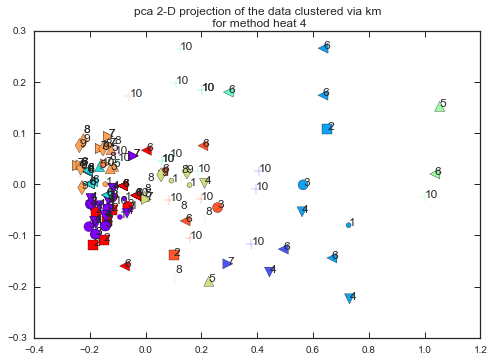

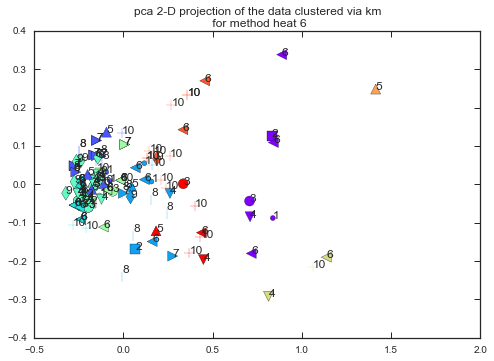

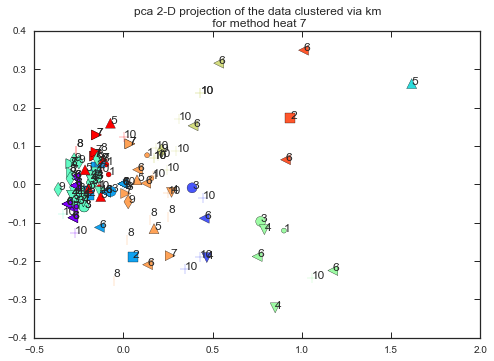

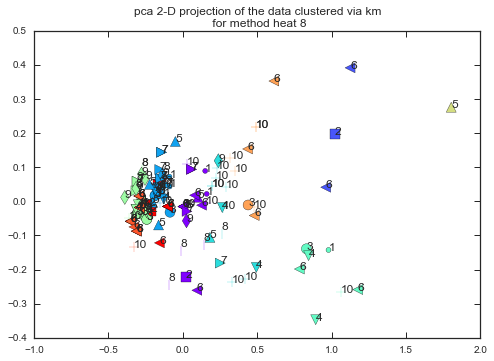

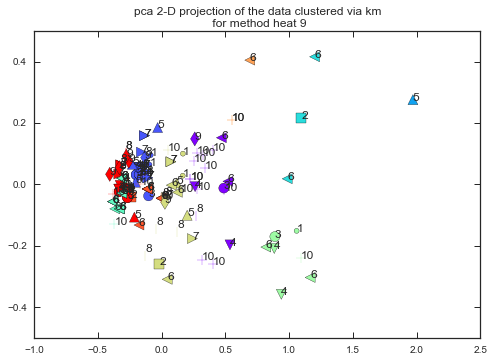

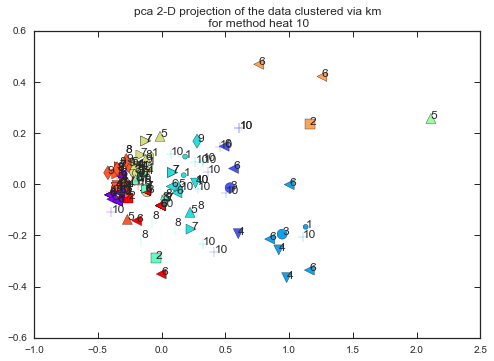

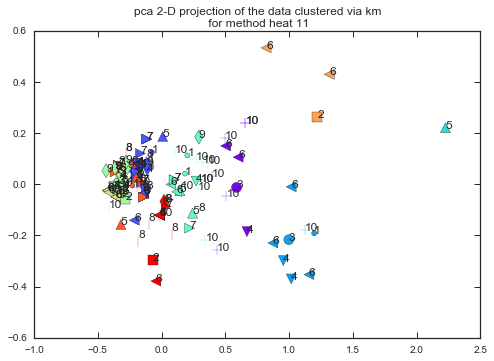

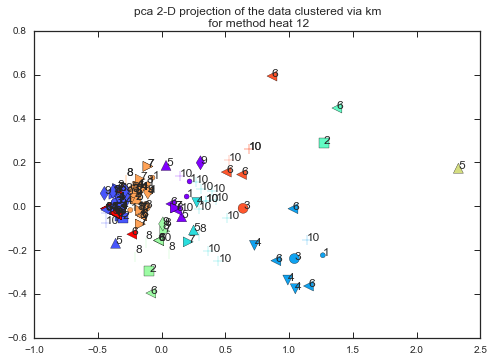

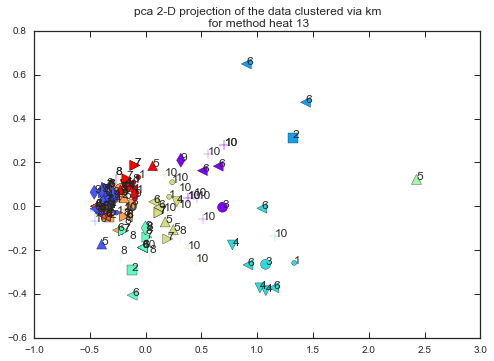

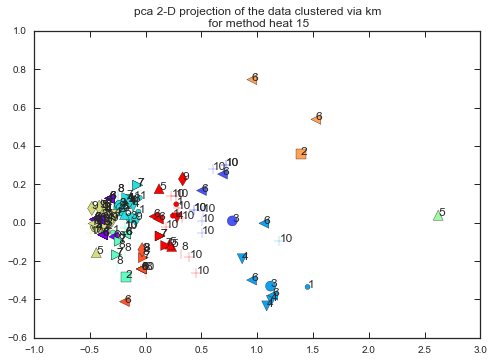

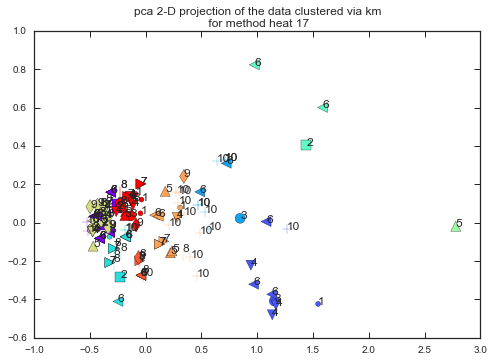

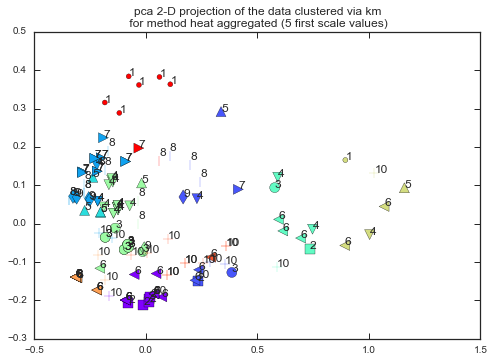

smax= 18  and smin= 4


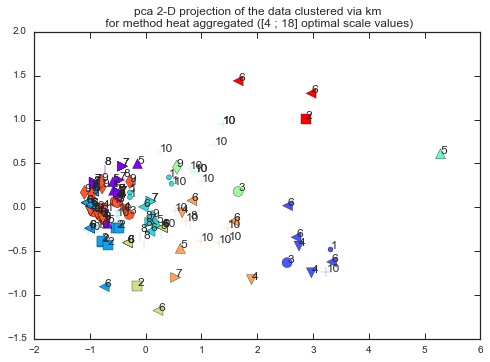

smax= 14  and smin= 2


start= 0
start= 7
start= 14
start= 21
start= 28
start= 35
start= 42
start= 49
start= 55
start= 61
start= 67
start= 73
start= 79
start= 85
start= 91
start= 96
start= 101
start= 106
start= 111
start= 116
start= 121


2017-10-10 08:59:49,305:[INFO](pygsp.filters.filter.__init__): Heat : has to compute lmax
2017-10-10 08:59:49,321:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:59:49,346:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:59:49,371:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:59:49,394:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:59:49,422:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:59:49,449:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:59:49,482:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:59:49,503:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:59:49,534:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 08:59:49,561:[INFO](pygsp.filters.filter.analysis): The analysis method

Creating Vertex Features matrix
V is a 147 by 121 matrix.
Node-role matrix is of dimensions 147 by 10
[[  999.             0.12320675    12.         ...,     0.01296549
      0.01296549    12.        ]
 [ 1680.             0.13918017     6.         ...,     0.00645826
      0.00645826     6.        ]
 [  141.             0.12289562     6.         ...,     0.00656691
      0.00656691     6.        ]
 ..., 
 [    0.             0.08795181     2.         ...,     0.00314467
      0.00314467     2.        ]
 [    0.             0.08811104     2.         ...,     0.00298587
      0.00298587     2.        ]
 [    0.             0.10138889     2.         ...,     0.0036429
      0.0036429      2.        ]]
[[ 0.          0.          0.00200695  0.          0.          0.          0.
   0.00201421]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.15883438  0.02046204  0.12066231  0.          0.          0.05570468
   0.05569628  0.12064105]
 [ 0

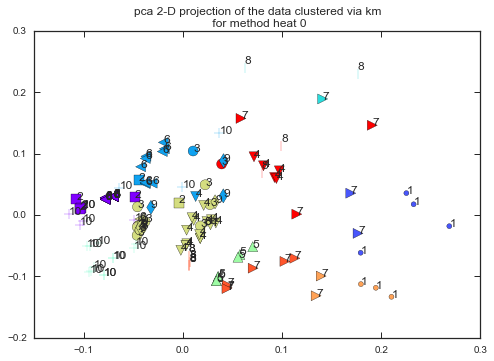

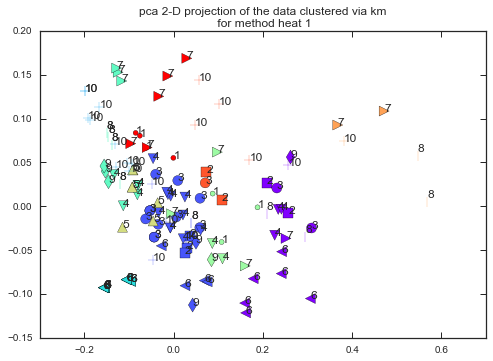

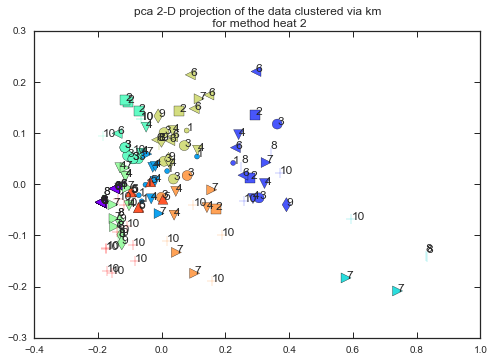

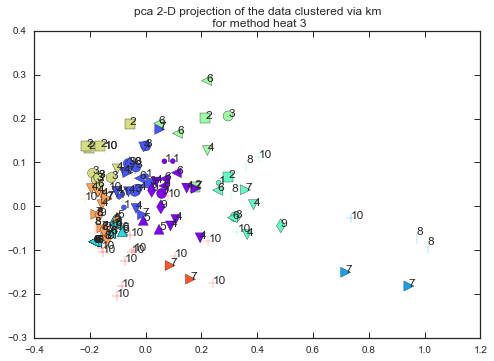

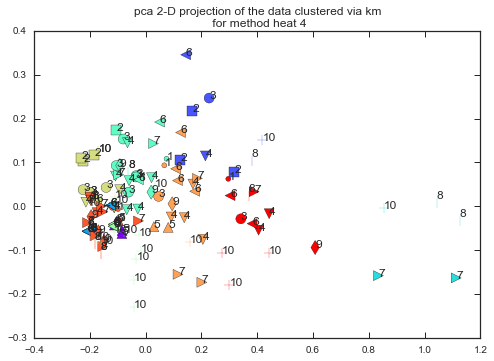

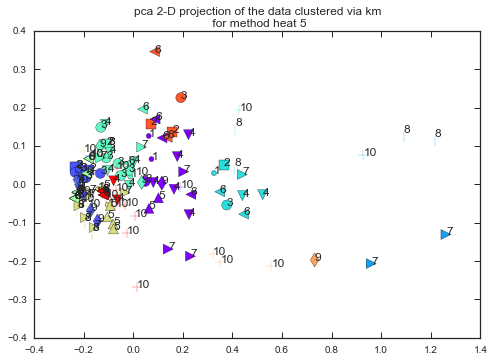

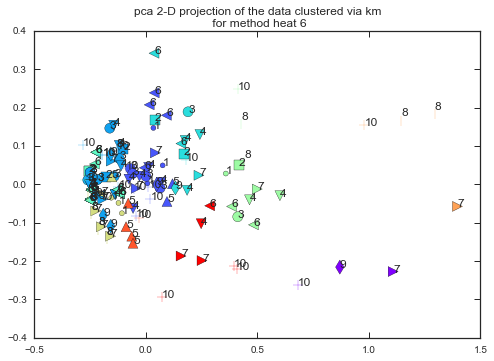

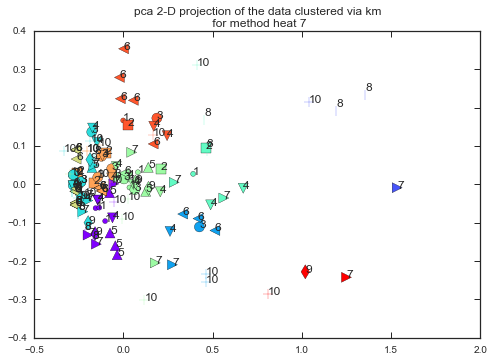

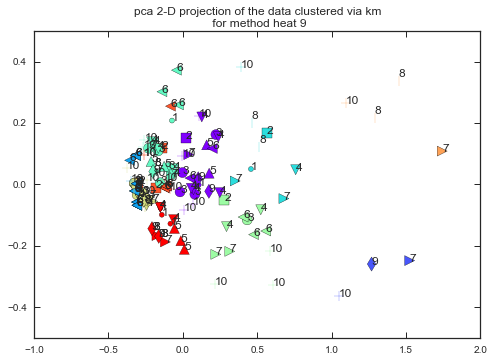

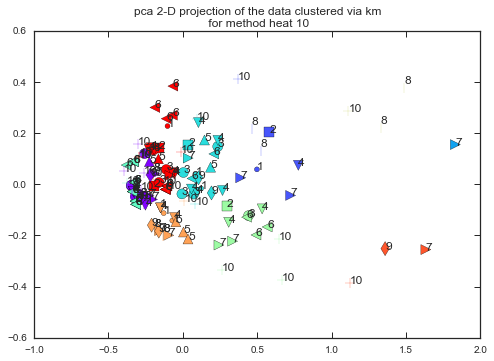

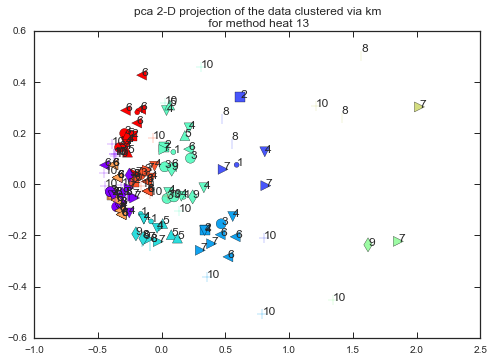

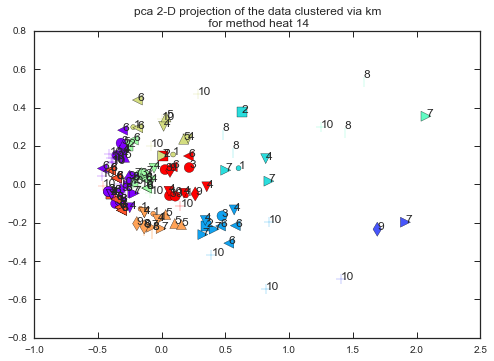

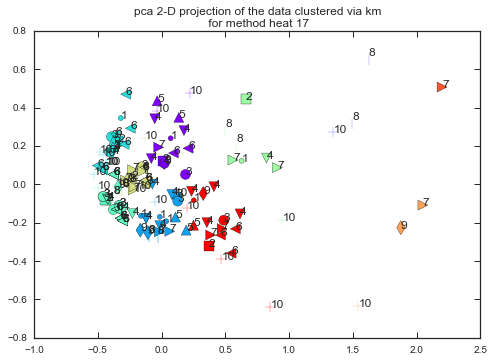

smax= 18  and smin= 4


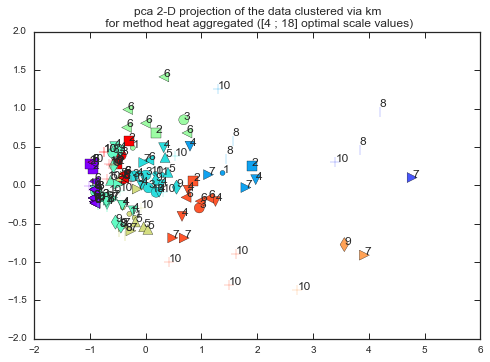

smax= 15  and smin= 2


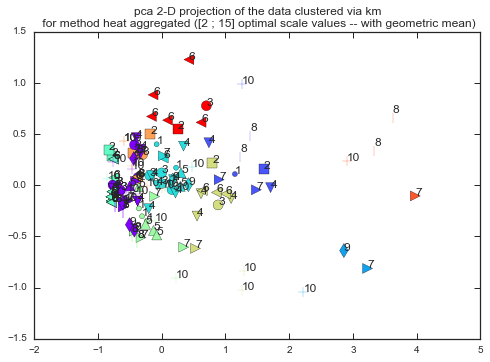

start= 0
start= 7
start= 14
start= 21
start= 28
start= 35
start= 42
start= 49
start= 55
start= 61
start= 67
start= 73
start= 79
start= 85
start= 91
start= 96
start= 101
start= 106
start= 111
start= 116
start= 121


2017-10-10 09:03:24,343:[INFO](pygsp.filters.filter.__init__): Heat : has to compute lmax
2017-10-10 09:03:24,356:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:03:24,405:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:03:24,442:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:03:24,485:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:03:24,521:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:03:24,553:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:03:24,588:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:03:24,626:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:03:24,670:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:03:24,704:[INFO](pygsp.filters.filter.analysis): The analysis method

Creating Vertex Features matrix
V is a 147 by 107 matrix.
Node-role matrix is of dimensions 147 by 10
[[   719.              0.147923       12.         ...,      0.0135175
       0.0135175      12.        ]
 [     0.              0.14732593      4.         ...,      0.0048709
       0.0048709       4.        ]
 [  1681.              0.17176471      8.         ...,      0.00910829
       0.00910829      8.        ]
 ..., 
 [ 14884.              0.28571429     22.         ...,      0.02529053
       0.02529053     22.        ]
 [     0.              0.22256098      2.         ...,      0.00297468
       0.00297468      2.        ]
 [     0.              0.17056075      2.         ...,      0.00332448
       0.00332448      2.        ]]
[[ 0.1152029   0.          0.00714725  0.          0.          0.          0.
   0.00714151]
 [ 0.          0.03299282  0.06619454  0.          0.          0.05470673
   0.05470483  0.06619542]
 [ 0.04782873  0.08363192  0.16007466  0.06497021  0.05175667 

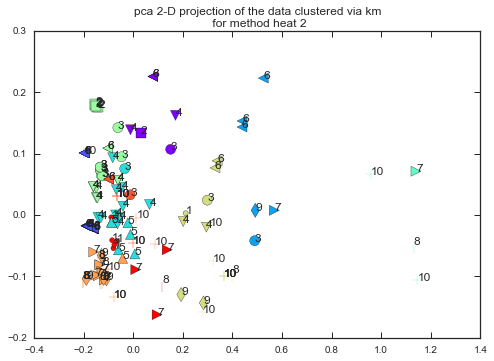

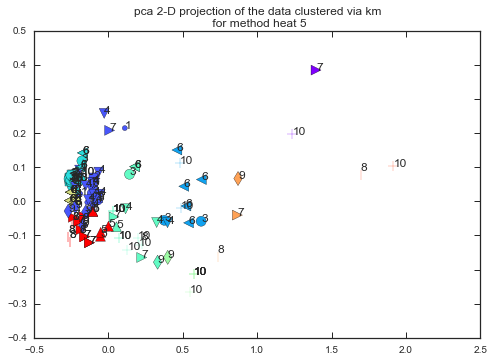

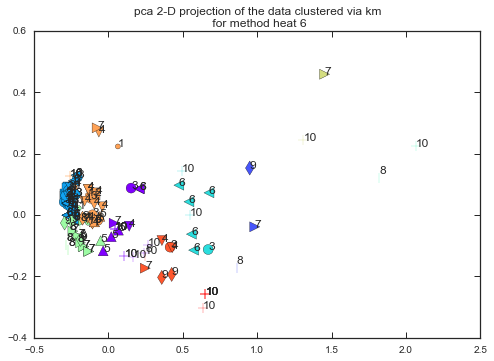

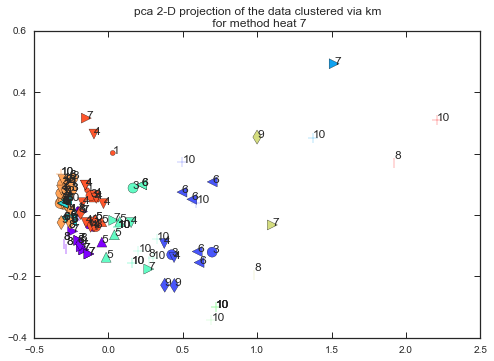

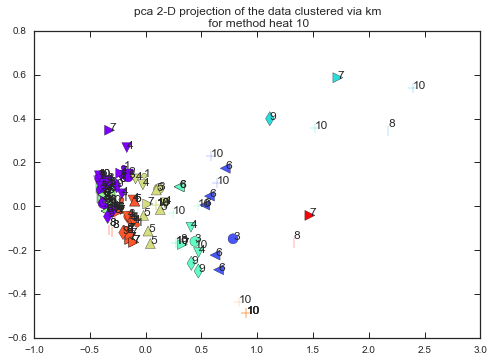

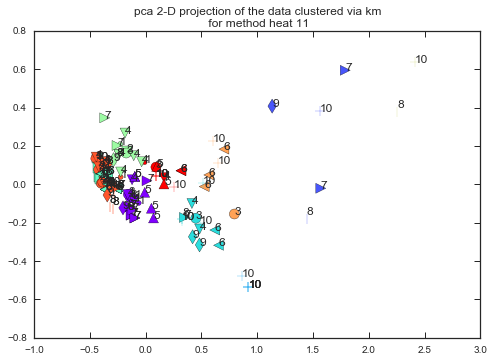

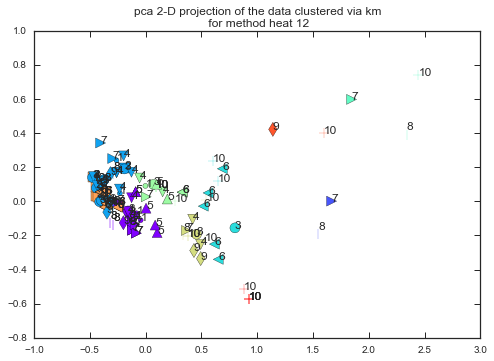

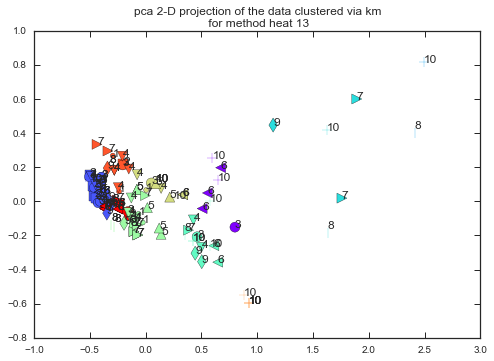

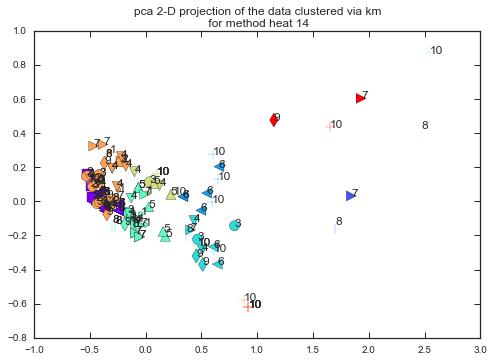

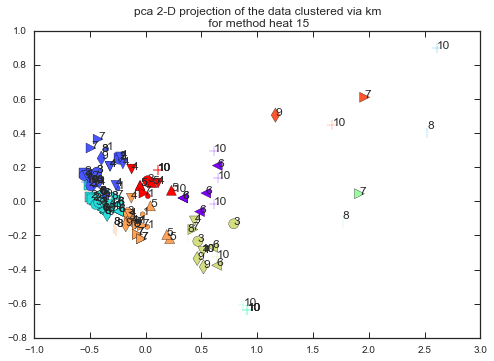

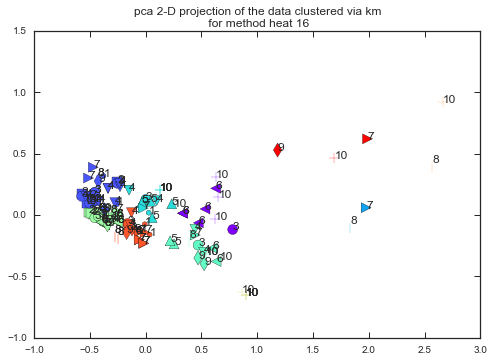

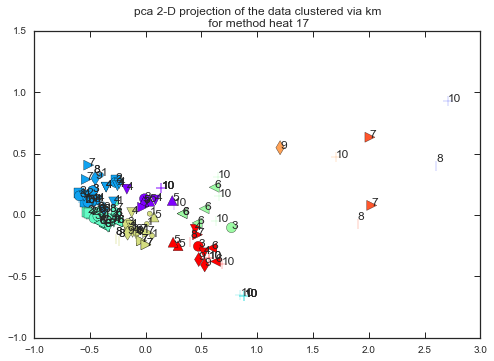

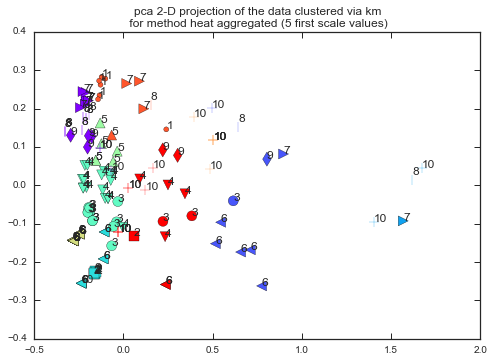

smax= 18  and smin= 2


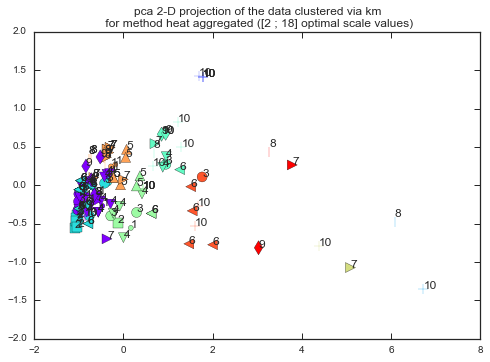

smax= 10  and smin= 2


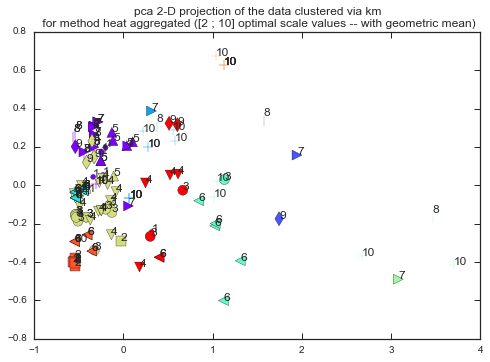

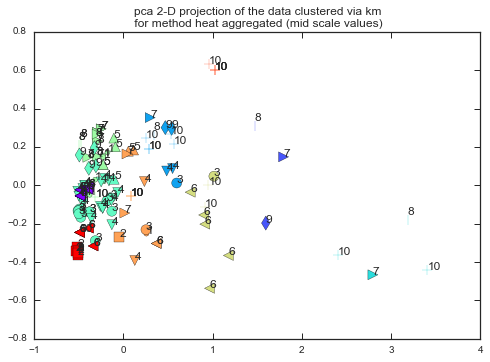

start= 0
start= 7
start= 14
start= 21
start= 28
start= 35
start= 42
start= 49
start= 55
start= 61
start= 67
start= 73
start= 79
start= 85
start= 91
start= 96
start= 101
start= 106
start= 111
start= 116
start= 121


2017-10-10 09:07:29,739:[INFO](pygsp.filters.filter.__init__): Heat : has to compute lmax
2017-10-10 09:07:29,751:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:07:29,785:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:07:29,838:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:07:29,926:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:07:29,981:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:07:30,082:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:07:30,141:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:07:30,193:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:07:30,242:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:07:30,293:[INFO](pygsp.filters.filter.analysis): The analysis method

Creating Vertex Features matrix
V is a 147 by 110 matrix.
Node-role matrix is of dimensions 147 by 10
[[  719.             0.13024086    12.         ...,     0.01355325
      0.01355325    12.        ]
 [    0.             0.11541502     4.         ...,     0.00491656
      0.00491656     4.        ]
 [    1.             0.11550633     6.         ...,     0.00697449
      0.00697449     6.        ]
 ..., 
 [    0.             0.16043956     2.         ...,     0.00294315
      0.00294315     2.        ]
 [  290.             0.12943262     4.         ...,     0.00681859
      0.00681859     4.        ]
 [ 3816.             0.19466667    10.         ...,     0.01247475
      0.01247475    10.        ]]
[[ 0.08046929  0.02626603  0.00253531  0.          0.          0.          0.
   0.00253724]
 [ 0.          0.10238632  0.22894475  0.13843199  0.13534485  0.19830227
   0.19831865  0.22894706]
 [ 0.          0.07995344  0.0036999   0.12321779  0.13310053  0.          0.
   0.0036933 ]
 [ 

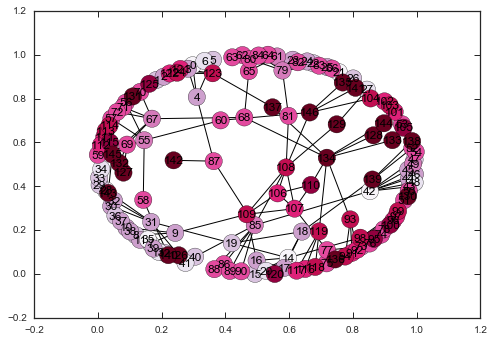

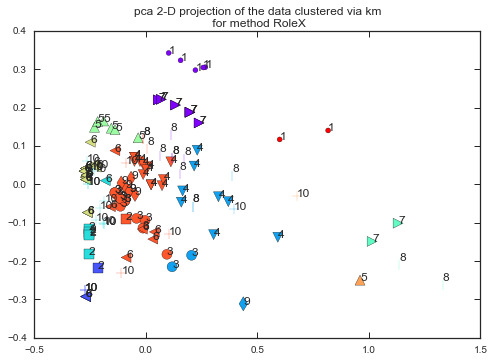

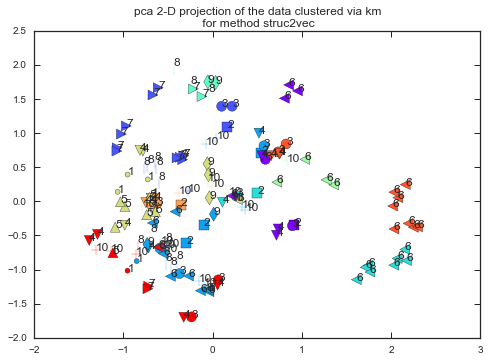

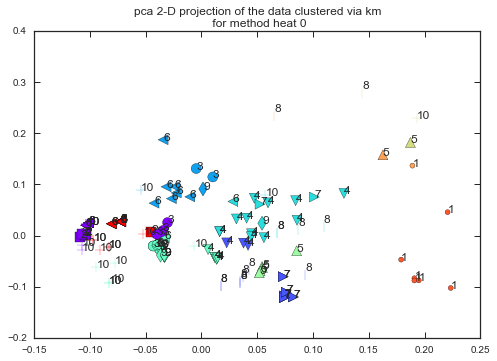

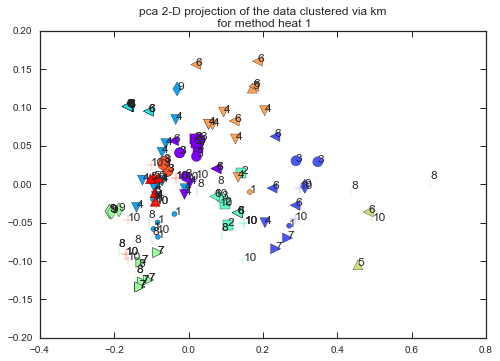

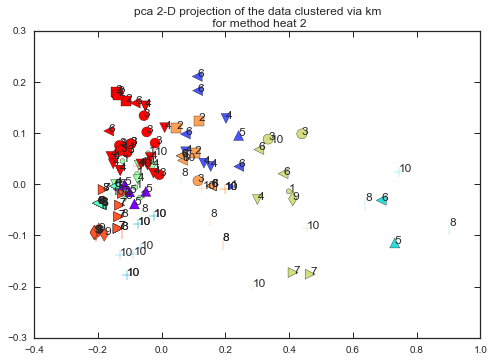

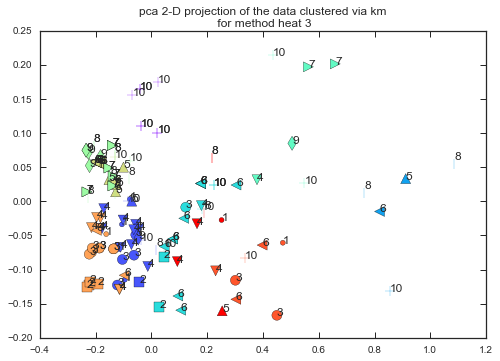

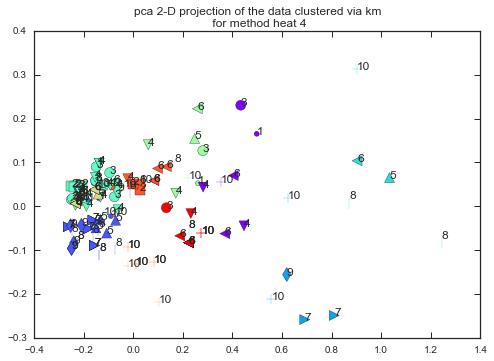

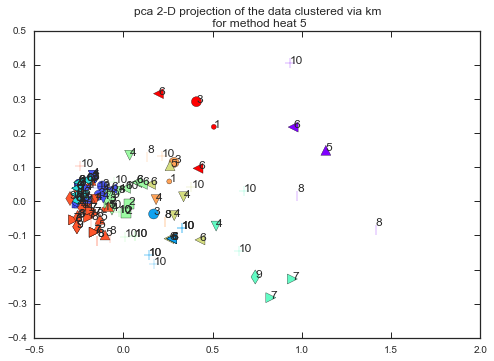

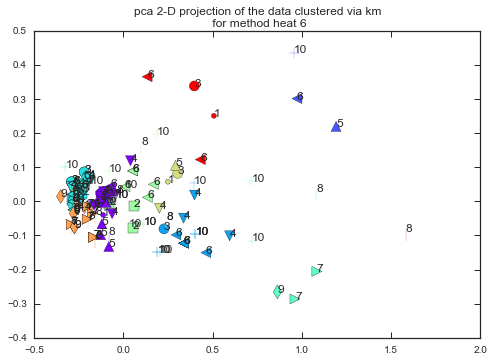

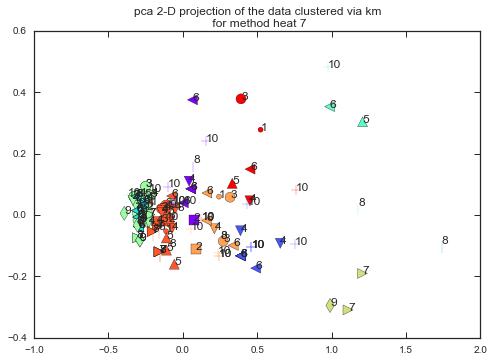

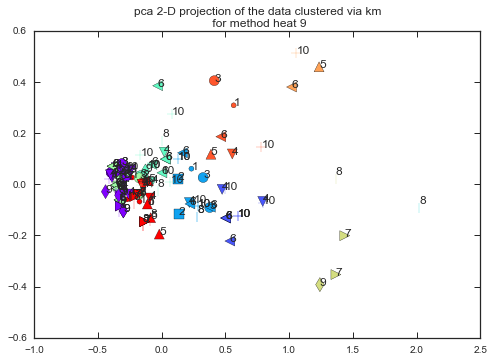

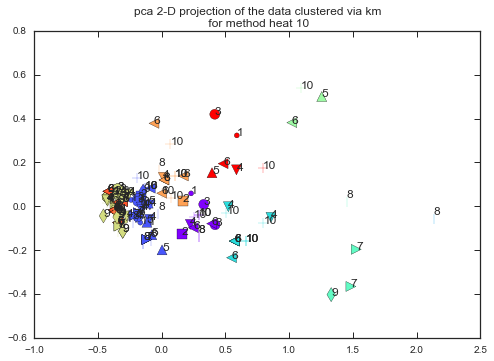

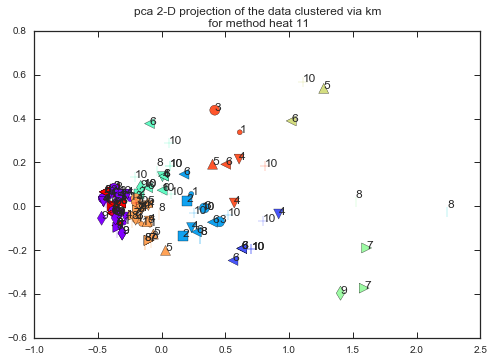

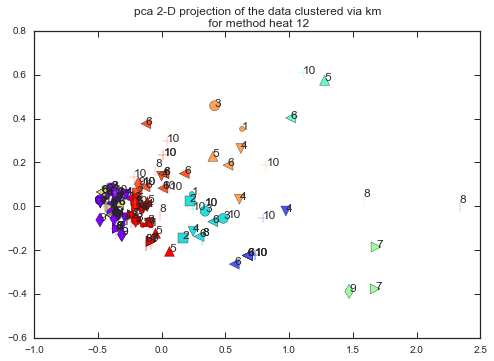

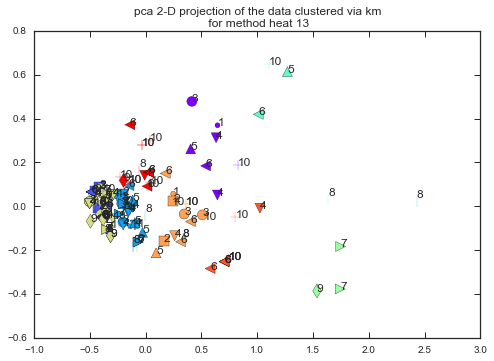

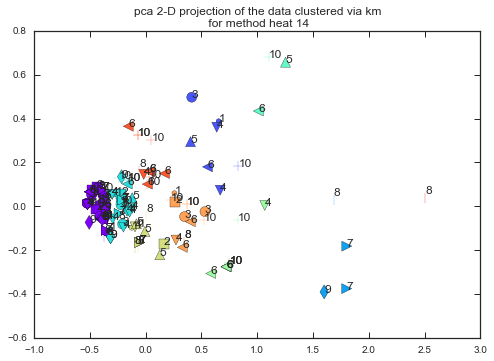

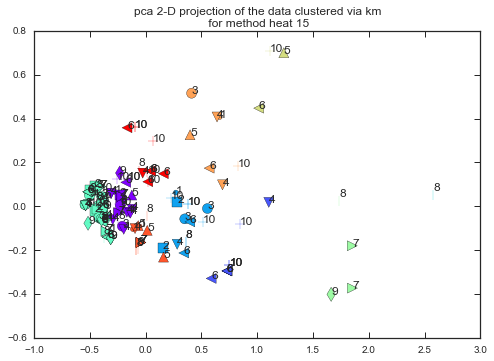

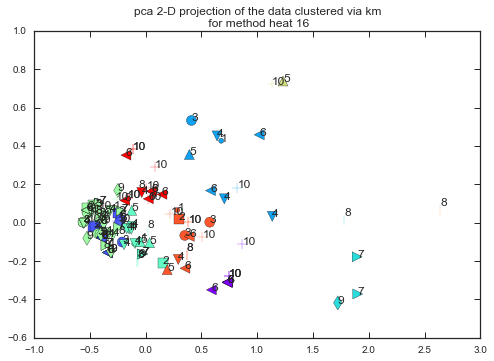

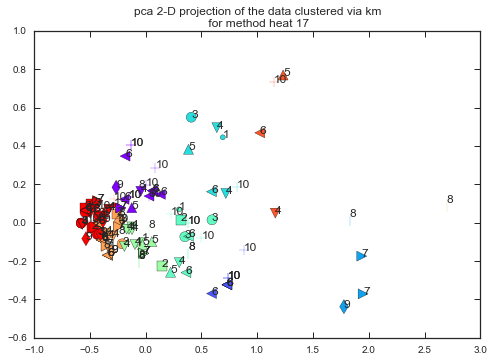

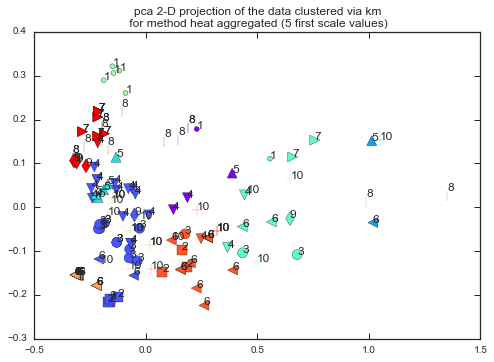

smax= 18  and smin= 3


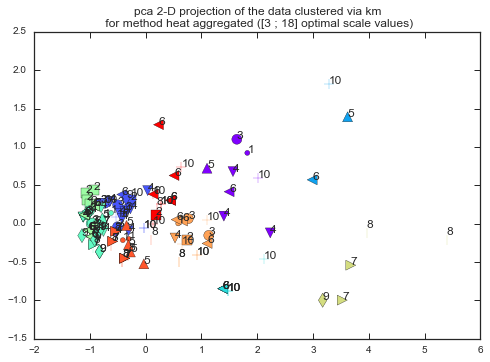

smax= 11  and smin= 2


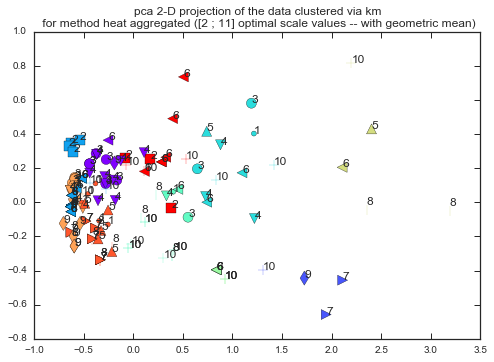

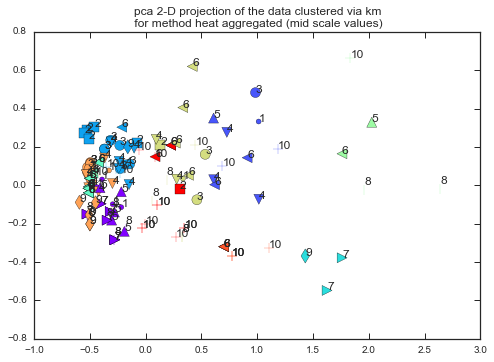

start= 0
start= 7
start= 14
start= 21
start= 28
start= 35
start= 42
start= 49
start= 55
start= 61
start= 67
start= 73
start= 79
start= 85
start= 91
start= 96
start= 101
start= 106
start= 111
start= 116
start= 121


2017-10-10 09:11:36,093:[INFO](pygsp.filters.filter.__init__): Heat : has to compute lmax
2017-10-10 09:11:36,105:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:11:36,139:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:11:36,204:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:11:36,336:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:11:36,398:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:11:36,476:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:11:36,542:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:11:36,606:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:11:36,667:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:11:36,757:[INFO](pygsp.filters.filter.analysis): The analysis method

Creating Vertex Features matrix
V is a 147 by 106 matrix.
Node-role matrix is of dimensions 147 by 10
[[ 1699.             0.15256008    14.         ...,     0.01586045
      0.01586045    14.        ]
 [    0.             0.13260672     4.         ...,     0.00492969
      0.00492969     4.        ]
 [    1.             0.13272727     6.         ...,     0.00700014
      0.00700014     6.        ]
 ..., 
 [    0.             0.13734713     2.         ...,     0.0029446
      0.0029446      2.        ]
 [ 7356.             0.21823617    12.         ...,     0.01494503
      0.01494503    12.        ]
 [ 1958.             0.15852334     6.         ...,     0.00859422
      0.00859422     6.        ]]
[[ 0.          0.          0.00893516  0.          0.          0.          0.
   0.00887663]
 [ 0.          0.05070089  0.12344739  0.03728796  0.00667651  0.08143849
   0.08142347  0.12352659]
 [ 0.          0.04747875  0.          0.0483174   0.06246015  0.          0.
   0.        ]
 [ 0

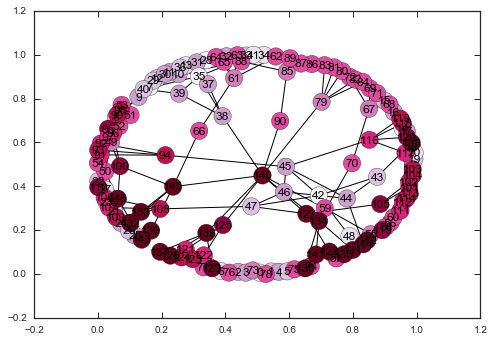

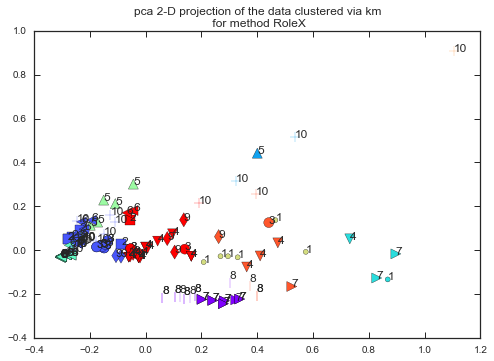

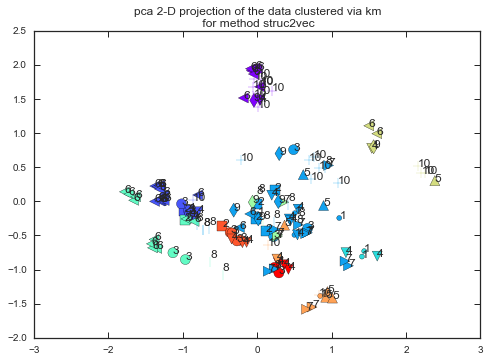

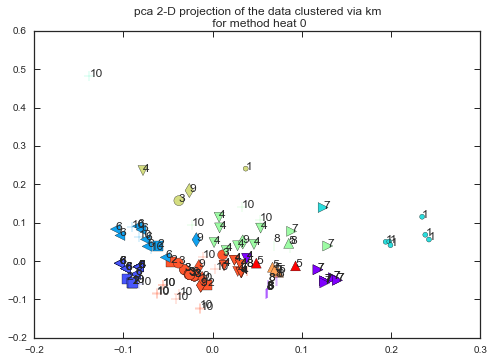

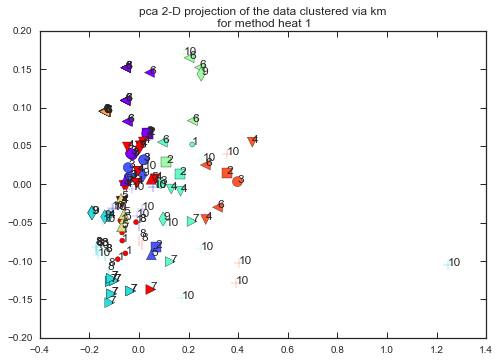

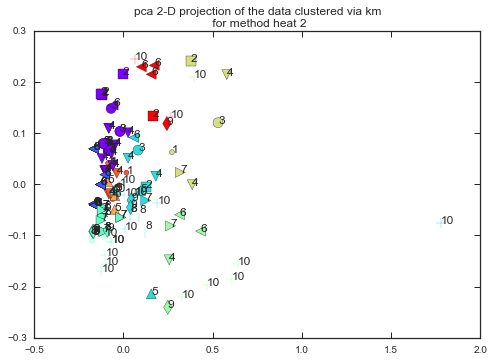

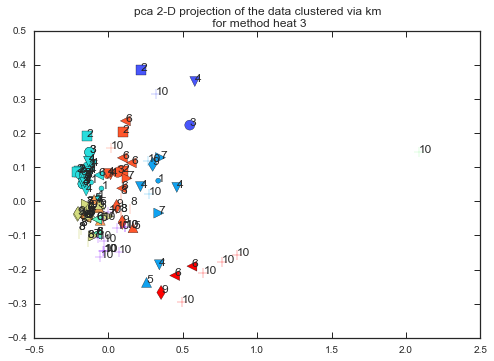

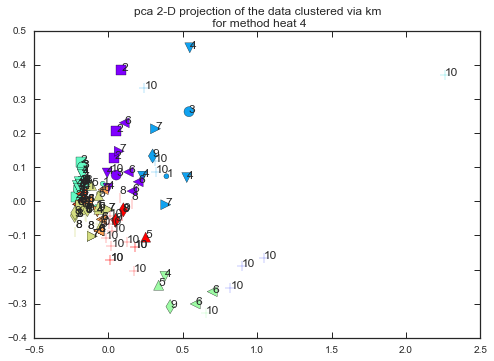

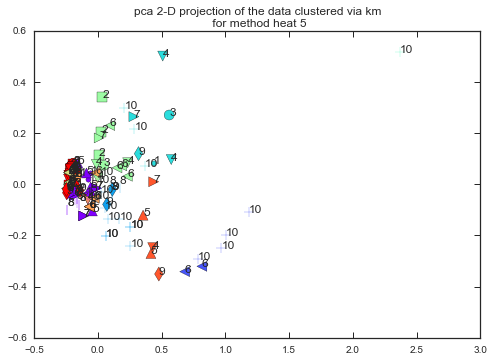

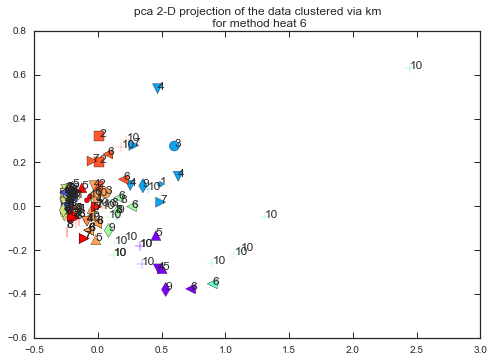

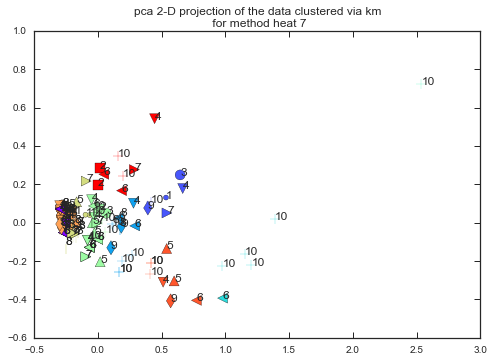

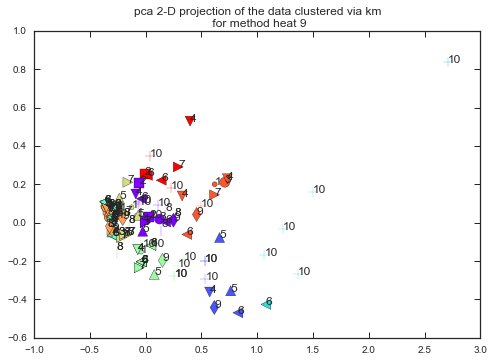

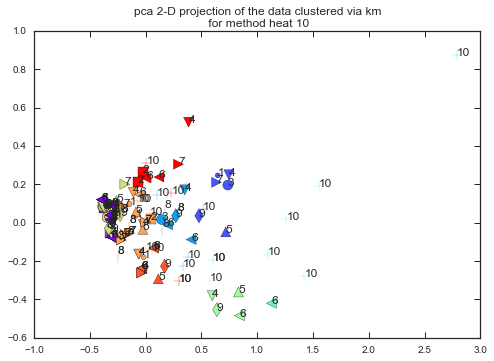

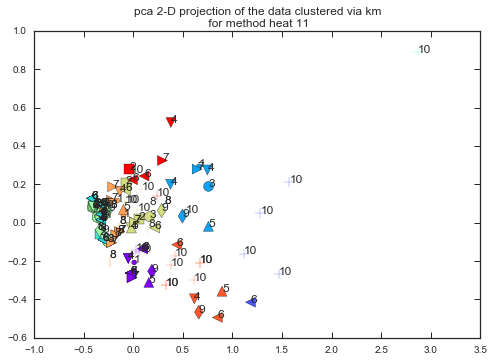

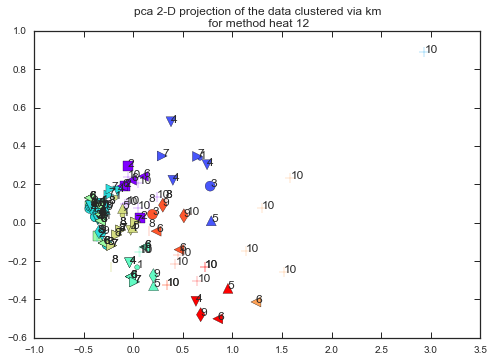

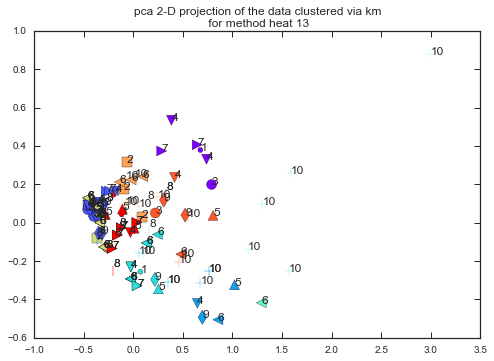

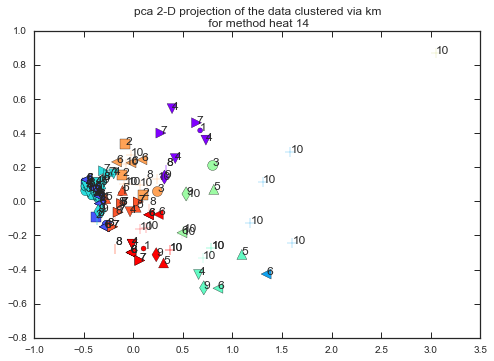

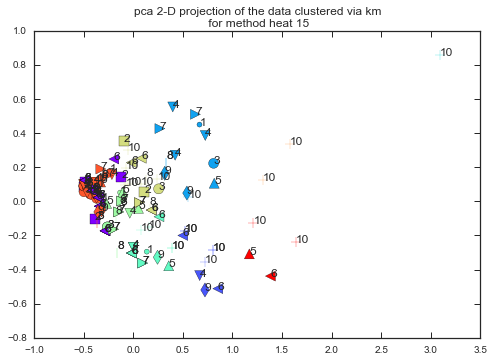

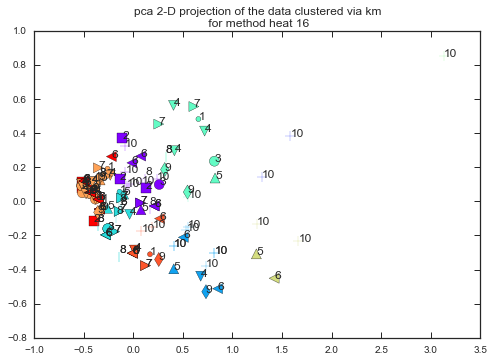

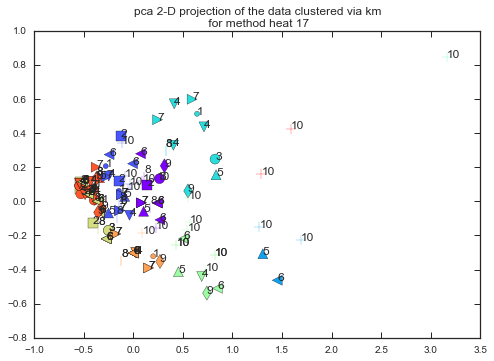

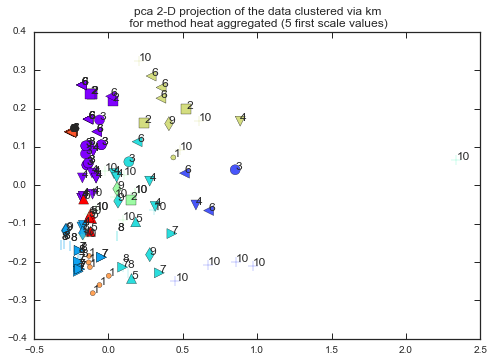

smax= 18  and smin= 3


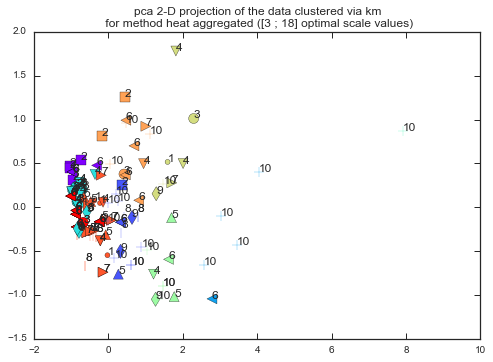

smax= 13  and smin= 2


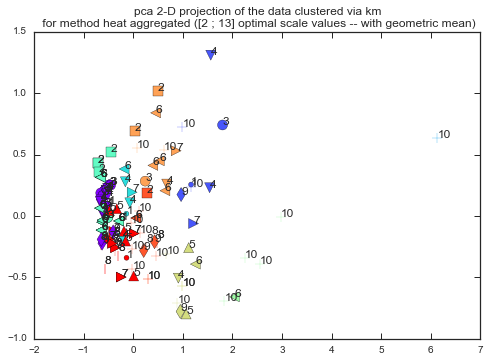

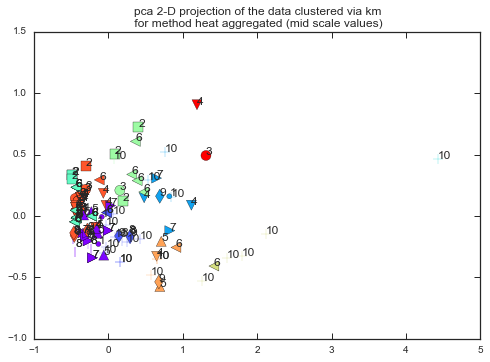

start= 0
start= 7
start= 14
start= 21
start= 28
start= 35
start= 42
start= 49
start= 55
start= 61
start= 67
start= 73
start= 79
start= 85
start= 91
start= 96
start= 101
start= 106
start= 111
start= 116
start= 121


2017-10-10 09:15:46,064:[INFO](pygsp.filters.filter.__init__): Heat : has to compute lmax
2017-10-10 09:15:46,078:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:15:46,149:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:15:46,213:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:15:46,271:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:15:46,321:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:15:46,401:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:15:46,460:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:15:46,507:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:15:46,541:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-10 09:15:46,592:[INFO](pygsp.filters.filter.analysis): The analysis method

Creating Vertex Features matrix
V is a 147 by 119 matrix.
Node-role matrix is of dimensions 147 by 10
[[ 3870.             0.09474367    12.         ...,     0.01314464
      0.01314464    12.        ]
 [ 4386.             0.10231254     6.         ...,     0.00712412
      0.00712412     6.        ]
 [  130.             0.09389068     6.         ...,     0.00681435
      0.00681435     6.        ]
 ..., 
 [    0.             0.11937858     2.         ...,     0.00328521
      0.00328521     2.        ]
 [    0.             0.11736334     2.         ...,     0.00289303
      0.00289303     2.        ]
 [  290.             0.11937858     4.         ...,     0.00668241
      0.00668241     4.        ]]
[[ 0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.15509054  0.0434367   0.05845179  0.02148861  0.04386608
   0.04386673  0.04343607]
 [ 0.          0.          0.          0.          0.01874998  0.          0.
   0.        ]
 [ 

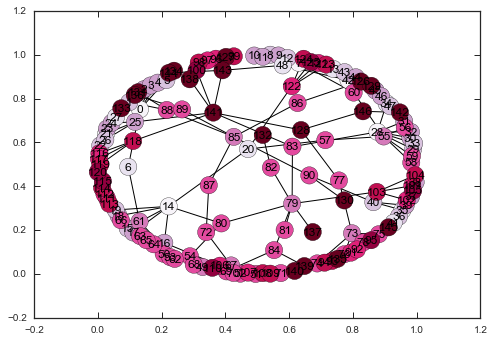

In [ ]:
name_graph='PA_1plus30'
D_PA1={}
chi_PA1={} 
Perf_PA1={}
D_classes_PA1={}
D_var_PA1={}
Ff_PA1={k: [] for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']}
Var_PA1={k: [] for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']}
D_var_PA1_tot={ }
D_classes_PA1_tot={}
if !load_data_from_cache:
    for i in range(20):
        taus=range(1,20,1)
        G,colors, index_roles, label_shape=build_lego_structure_from_structure(list_shapes, start=0,plot=True,\
                                                    savefig=False,graph_type='nx.barabasi_albert_graph', graph_args=[1],\
                                                    save2text='/Users/cdonnat/Desktop/structural_equivalents/graphs/PA_1_plus30_',\
                                                    add_node=21)
        N=G.number_of_nodes()
        heat_print=heat_diffusion(G,taus,diff_type="immediate",type_graph="nx")
        nb_clust=len(np.unique(index_roles))
        D_PA1[i], chi_PA1[i], Perf_PA1[i],D_classes_PA1[i],D_var_PA1[i]=clustering_comparative_analysis(G, index_roles, heat_print,nb_clust,dirpath='../../structural_equivalents',graph_nodes_name=name_graph+'_nodes.txt',graph_edges_name=name_graph+'_edges.txt',agg_max=5,struc2vec_input=name_graph+'_edges.txt',struc2vec_output=name_graph+'_struc2vec.txt')
        for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']:
            D, F,Var_within, Var_between=F_test(chi_PA1[i][k], index_roles)
            def square(x): return x**2
            myfunc=np.vectorize(square)
            m=np.array([chi_PA1[i][k].mean(0)]*N).reshape((N,-1))
            Var=1.0/(N-1)*myfunc(chi_PA1[i][k]-m).sum()
            Ff_PA1[k].append(F)
            Var_PA1[k].append(np.median(np.diag(1.0/Var*D_var_PA1[i][k])))

    data=[D_PA1, chi_PA1, Perf_PA1,D_classes_PA1,D_var_PA1,Ff_PA1,Var_PA1]
    with open('../caches/PA1_trials.pkl', "wb") as f:
        pickle.dump(data, f)  
else:
    with open('../caches/PA1_trials.pkl', "rb") as f:
        D_PA1, chi_PA1, Perf_PA1,D_classes_PA1,D_var_PA1,Ff_PA1,Var_PA1=pickle.load(f)  

#### PA 3 plus  30 nodes

In [ ]:
name_graph='PA_3plus30'
D_PA3={}
chi_PA3={} 
Perf_PA3={}
D_classes_PA3={}
D_var_PA3={}
Ff_PA3={k: [] for k in ['RoleX','chi0','chi1','chi2','chi_agg1_5','chi_opt2']}
Var_PA3={k: [] for k in ['RoleX','chi0','chi1','chi2','chi_agg1_5','chi_opt2']}
D_var_PA3_tot={}
D_classes_PA3_tot={}



if !load_data_from_cache:
    for i in range(20):
        taus=range(1,20,1)
        G,colors, index_roles, label_shape=build_lego_structure_from_structure(list_shapes, start=0,plot=True,\
                                                    savefig=False,graph_type='nx.barabasi_albert_graph', graph_args=[3],\
                                                    save2text='/Users/cdonnat/Desktop/structural_equivalents/graphs/PA_1_plus30_',\
                                                    add_node=21)
        heat_print=heat_diffusion(G,taus,diff_type="immediate",type_graph="nx")
        nb_clust=len(np.unique(index_roles))
        D_PA3[i], chi_PA3[i], Perf_PA3[i],D_classes_PA3[i],D_var_PA3[i]=clustering_comparative_analysis(G, index_roles, heat_print,nb_clust,dirpath='../../structural_equivalents',graph_nodes_name=name_graph+'_nodes.txt',graph_edges_name=name_graph+'_edges.txt',agg_max=5,struc2vec_input=name_graph+'_edges.txt',struc2vec_output=name_graph+'_struc2vec.txt')
        for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']:
            D, F,Var_within, Var_between=F_test(chi_PA3[i][k], index_roles)
            def square(x): return x**2
            myfunc=np.vectorize(square)
            m=np.array([chi_PA3[i][k].mean(0)]*N).reshape((N,-1))
            Var=1.0/(N-1)*myfunc(chi_PA3[i][k]-m).sum()
            Ff_PA3[k].append(F)
            Var_PA3[k].append(np.median(np.diag(1.0/Var*D_var_PA3[i][k])))
    data=[D_PA3, chi_PA3, Perf_PA3,D_classes_PA3,D_var_PA3,Ff_PA3,Var_PA3]
    with open('../caches/PA3_trials.pkl', "wb") as f:
        pickle.dump(data, f) 
else:
    with open('../caches/PA3_trials.pkl', "rb") as f:
        D_PA3, chi_PA3, Perf_PA3,D_classes_PA3,D_var_PA3,Ff_PA3,Var_PA3=pickle.load( f) 
    

#### PA 5 plus 30 nodes

In [ ]:
Ff_PA5={k: [] for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']}
Var_PA5={k: [] for k in ['RoleX','struc2vec','chi0','chi1','chi2','chi_agg1_5','chi_opt2']}
D_PA5={}
chi_PA5={} 
Perf_PA5={}
D_classes_PA5={}
D_var_PA5={}

D_var_PA5_tot={}
D_classes_PA5_tot={}

if !load_data_from_cache:
    for i in range(20):
        taus=range(1,20,1)
        name_graph='PA_5plus30'
        G,colors, index_roles, label_shape=build_lego_structure_from_structure(list_shapes, start=0,plot=True,\
                                                    savefig=False,graph_type='nx.barabasi_albert_graph', graph_args=[5],\
                                                    save2text='/Users/cdonnat/Desktop/structural_equivalents/graphs/PA_5_plus30_',\
                                                    add_node=21)
        heat_print=heat_diffusion(G,taus,diff_type="immediate",type_graph="nx")
        nb_clust=len(np.unique(index_roles))
        D_PA5[i], chi_PA5[i], Perf_PA5[i],D_classes_PA5[i],D_var_PA5[i]=clustering_comparative_analysis(G, index_roles, heat_print,nb_clust,dirpath='../../structural_equivalents',graph_nodes_name=name_graph+'_nodes.txt',graph_edges_name=name_graph+'_edges.txt',agg_max=5,struc2vec_input=name_graph+'_edges.txt',struc2vec_output=name_graph+'_struc2vec.txt')
        for k in ['RoleX','chi0','chi1','chi2','chi_agg1_5','chi_opt2']:
            D, F,Var_within, Var_between=F_test(chi_PA5[i][k], index_roles)
            def square(x): return x**2
            myfunc=np.vectorize(square)
            m=np.array([chi_PA5[i][k].mean(0)]*N).reshape((N,-1))
            Var=1.0/(N-1)*myfunc(chi_PA5[i][k]-m).sum()
            Ff_PA5[k].append(F)
            Var_PA5[k].append(np.median(np.diag(1.0/Var*D_var_PA5[i][k])))
    data=[D_PA5, chi_PA5, Perf_PA5,D_classes_PA5,D_var_PA5,Ff_PA5,Var_PA5]
    with open('../caches/PA5_trials.pkl', "wb") as f:
        pickle.dump(data, f) 
else:
    with open('../caches/PA5_trials.pkl', "rb") as f:
        D_PA5, chi_PA5, Perf_PA5,D_classes_PA5,D_var_PA5,Ff_PA5,Var_PA5=pickle.load(f) 
    

In [ ]:
Perf_PA5.sort_values(by='homogeneity',ascending=False)
